In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
import os
import cv2 
import random
from PIL import Image
import pandas as pd
from sklearn.preprocessing import StandardScaler

### 1. Train a SOM with your own collection of images


In [3]:
def normalise(train, p):
    min_d = np.min(train)
    max_d = np.max(train)
    normalised_p = (p-min_d)/(max_d - min_d)
    return normalised_p

In [4]:
def denormalise(train, p):
    min_d = np.min(train)
    max_d = np.max(train)
    denormalised_p = p * (max_d - min_d) + min_d
    return denormalised_p

In [5]:
# Return the (g,h) index of the BMU in the grid
def find_BMU(SOM,x):
    distSq = (np.square(SOM - x)).sum(axis=2)
    return np.unravel_index(np.argmin(distSq, axis=None), distSq.shape)

# Update the weights of the SOM cells when given a single training example
# and the model parameters along with BMU coordinates as a tuple
def update_weights(SOM, train_ex, learn_rate, radius_sq, 
                   BMU_coord, step=3):
    g, h = BMU_coord
    #if radius is close to zero then only BMU is changed
    if radius_sq < 1e-3:
        SOM[g,h,:] += learn_rate * (train_ex - SOM[g,h,:])
        return SOM
    # Change all cells in a small neighborhood of BMU
    for i in range(max(0, g-step), min(SOM.shape[0], g+step)):
        for j in range(max(0, h-step), min(SOM.shape[1], h+step)):
            dist_sq = np.square(i - g) + np.square(j - h)
            dist_func = np.exp(-dist_sq / 2 / radius_sq)
            SOM[i,j,:] += learn_rate * dist_func * (train_ex - SOM[i,j,:])   
    return SOM    

# Main routine for training an SOM. It requires an initialized SOM grid
# or a partially trained grid as parameter
def train_SOM(SOM, train_data, learn_rate = .1, radius_sq = 1, 
             lr_decay = .1, radius_decay = .1, epochs = 10):    
    learn_rate_0 = learn_rate
    radius_0 = radius_sq
    for epoch in np.arange(0, epochs):
        random.shuffle(train_data)      
        for train_ex in train_data:
            g, h = find_BMU(SOM, train_ex)
            SOM = update_weights(SOM, train_ex, 
                                 learn_rate, radius_sq, (g,h))
        # Update learning rate and radius
        learn_rate = learn_rate_0 * np.exp(-epoch * lr_decay)
        radius_sq = radius_0 * np.exp(-epoch * radius_decay)            
    return SOM

In [156]:
# Dimension of the SOM grid
m = 10 
n = 10

train_data =[]

image_path = "Books Covers Images"

for image_file in os.listdir(image_path):
    image_file_path = os.path.join(image_path, image_file)
    image = Image.open(image_file_path)
    # Convert to RGB format if the image is in grayscale
    if image.mode != "RGB":
        image = image.convert("RGB")
    # Resize the image to a common size
    image = image.resize((50, 50))
    # Convert image to numpy array
    # image_array = np.array(image)
    train_data.append(image)


train_data = np.array(train_data)
# Normalised training data
n_train_data = normalise(train_data, train_data)

In [143]:
# # Dimension of the SOM grid
# m = 5 
# n = 5

# train_data = pd.read_csv ('combined_images.csv')


# train_data = np.array(train_data)
# # Normalised training data
# n_train_data = normalise(train_data, train_data)

In [169]:
# Initialize the SOM randomly
SOM = np.random.uniform(0,300,(m,n,3))

# to show the original vector space:
oSOM = denormalise(train_data, SOM)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


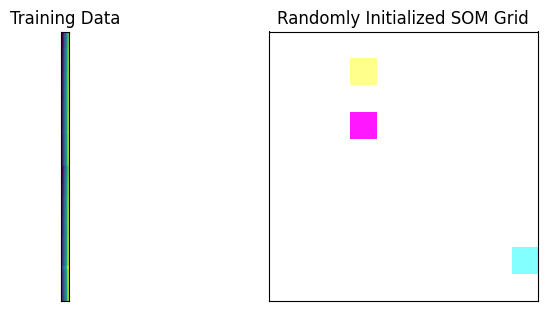

In [177]:
# Reshape train_data to have 3 channels
train_data = train_data.reshape((-1, 3))

# Get the dimensions of the SOM grid
# m, n, _ = SOM.shape

# Calculate the total number of pixels required to display the SOM grid
total_pixels = m * n

# Reshape the training data to match the total number of pixels in the SOM grid
train_data = train_data[:total_pixels]

# Display both the training matrix and the SOM grid
fig, ax = plt.subplots(
    nrows=1, ncols=2, figsize=(8, 3.5),
    subplot_kw=dict(xticks=[], yticks=[]))
ax[0].imshow(train_data) #.reshape(int(np.sqrt(total_pixels)), int(np.sqrt(total_pixels)), 3))
ax[0].set_title('Training Data')
ax[1].imshow(oSOM.astype(int))   
ax[1].set_title('Randomly Initialized SOM Grid')
plt.show() 